# Analysis and visualisation of experiment results
## Imports

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [214]:
import copy
from collections import defaultdict
from pathlib import Path

import hyperopt
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
import plotly.express as ex
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.linear_model import Lasso, ARDRegression, Ridge
import torch
import pickle

from src import config
from src.data.hts import DatasetUsage
from src.data.scaling import fit_label_scaler, StandardScaler
from src.data.utils import get_dataset
from src.evaluation.reporting import read_json_file
from src.nas.hyperopt import construct_search_space, _convert_to_gnn_architecture
from src.models import ActivationFunction, GNNLayerType
from src.nas.proxies import Ensemble, DEFAULT_PROXIES, ProxyCollection, ZiCo

## Utils

In [3]:
def _get_log_dir(dataset: str, experiment: str, data_usage: str) -> Path:
    return config.LOG_DIR / dataset / data_usage / experiment

In [182]:
datasets = ['AID1445', 'AID504329', 'AID624330', 'AID1465', 'AID1431-873', 'AID449756-435005', 'AID504313-2732', 'AID1259350-1224905']
metric_names = ['MeanAbsoluteError', 'RootMeanSquaredError', 'MaxError', 'PearsonCorrCoefSquared', 'ConceptCompleteness']
proxy_names = ['NumParams', 'SynFlow', 'GradientNorm', 'JacobianCovariance', 'Snip', 'ZiCo', 'Grasp', 'Fisher']
METRIC_HIGHER_IS_BETTER = {
    'MeanAbsoluteError': False,
    'RootMeanSquaredError': False,
    'MaxError': False,
    'PearsonCorrCoefSquared': True,
    'ConceptCompleteness': True,
}

In [5]:
def get_all_trial_results(log_dir: Path) -> pd.DataFrame:
    data = defaultdict(list)
    for p in log_dir.glob("*"):
        if p.is_dir():
            trial_id = p.name
            trial_metrics = read_json_file(p, 'metrics.json')
            trial_proxies = read_json_file(p, 'proxies.json')
            for version in trial_metrics:
                data['trial'].append(trial_id)
                data['version'].append(version)
                for name, metric in trial_metrics[version].items():
                    data[name].append(metric)
                for name, proxy in trial_proxies[version].items():
                    data[name].append(proxy)
    return pd.DataFrame(data)
                
    

In [6]:
def load_samples(dataset: str):
    path = _get_log_dir(dataset, 'sampled_results.pt', 'DROnly')
    return torch.load(path)

In [7]:
def load_trials(dataset: str, experiment: str):
    trials_path = _get_log_dir(dataset, experiment, 'DROnly') / 'trials.pkl'
    with open(trials_path, 'rb') as file:
        return pickle.load(file)

## Baseline Results
### R2 Box Plots

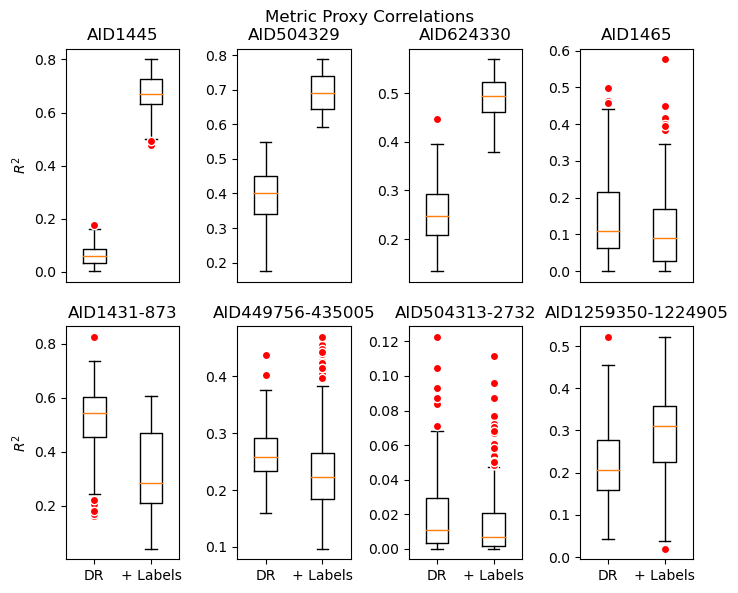

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(7, 6))
fig.suptitle("Metric Proxy Correlations")
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
fig.tight_layout()

axs[0][0].set_ylabel("$R^2$")
axs[1][0].set_ylabel("$R^2$")

for i, (ax, dataset) in enumerate(zip(axs.flatten(), datasets)):
    dr_df = get_all_trial_results(_get_log_dir(dataset, 'baseline_0', 'DROnly'))
    dr_with_labels_df = get_all_trial_results(_get_log_dir(dataset, 'baseline_0', 'DRWithSDLabels'))
    df = pd.DataFrame({'DR': dr_df['PearsonCorrCoefSquared'], '+ Labels': dr_with_labels_df['PearsonCorrCoefSquared']})
    ax.set_title(dataset)
    ax.boxplot(df, flierprops=red_circle, labels=df.columns, widths=0.4)
    if i < 4:
        ax.set_xticks([])
fig.savefig(config.FIGURES_DIR / 'baseline_r2_box_plot.png')

### Label and Prediction Distributions

In [ ]:
num_bins = 10
fig, axs = plt.subplots(2, 4, figsize=(4, 10))
fig.suptitle("Metric Proxy Correlations")

for dataset in datasets:
    raw_dataset = get_dataset(dataset, dataset_usage=DatasetUsage.DROnly)
    label_scaler = fit_label_scaler(raw_dataset, StandardScaler)
    model = _get_best_model(dataset)
    bins = np.linspace(0, 1, num_bins)
    hist(dataset.data.y, bins, alpha=0.5, label='Labels')
    hist(predictions, bins, alpha=0.5, label='Predictions')

## NAS
### Parallel Coordinates

In [9]:
search_space = construct_search_space('simple')

In [136]:
searched_archs = defaultdict(list)
for dataset in datasets:
    losses = []
    trials = load_trials(dataset, 'hyperopt_baseline_tpe_0')
    for trial in trials.trials:
        spec = hyperopt.base.spec_from_misc(trial['misc'])
        arch = hyperopt.space_eval(search_space, spec)
        searched_archs['No. Layers'].append(arch['layers']['num'])
        searched_archs['No. Features'].append(arch['layers']['hidden_features'])
        layers = {t.name: 0 for t in GNNLayerType}
        for layer in arch['layers']['layer_types']:
            layers[layer.name] += 1
        for t, count in layers.items():
            searched_archs['No. ' + t].append(count)
        searched_archs['Pooling Function'].append(arch['pool_func'].name)
        losses.append(trial['result']['metrics']['PearsonCorrCoefSquared'])
    losses = np.array(losses)
    losses = (losses - losses.min()) / (losses.max() - losses.min())
    searched_archs['Scaled R2'].extend(losses)

searched_architectures = pd.DataFrame(searched_archs)

In [134]:
searched_archs = defaultdict(list)
for dataset in datasets:
    trials = load_trials(dataset, 'hyperopt_baseline_tpe_0')
    trial = trials.best_trial
    spec = hyperopt.base.spec_from_misc(trial['misc'])
    arch = hyperopt.space_eval(search_space, spec)
    searched_archs['No. Layers'].append(arch['layers']['num'])
    searched_archs['No. Features'].append(arch['layers']['hidden_features'])
    layers = {t.name: 0 for t in GNNLayerType}
    for layer in arch['layers']['layer_types']:
        layers[layer.name] += 1
    for t, count in layers.items():
        searched_archs['No. ' + t].append(count)
    searched_archs['Pooling Function'].append(arch['pool_func'].name)
    losses = np.array(trials.losses())
    loss = trial['result']['metrics']['PearsonCorrCoefSquared']
    searched_archs['Scaled R2'].append((loss - losses.min()) / (losses.max() - losses.min()))

searched_architectures = pd.DataFrame(searched_archs)

In [151]:
fig = ex.parallel_coordinates(
    searched_architectures,
    color='Scaled R2',
    color_continuous_scale=ex.colors.diverging.Portland,
)
fig.write_html('bla.html', auto_open=True)

### Convergence

In [377]:
rand_losses = []
tpe_losses = []
for dataset in datasets:
    rand_trials = load_trials(dataset, 'hyperopt_baseline_0')
    tpe_trials = load_trials(dataset, 'hyperopt_baseline_tpe_0')
    rand_losses.append(torch.tensor([trial['result']['metrics']['PearsonCorrCoefSquared'] for trial in rand_trials]).cummax(0).values)
    tpe_losses.append(torch.tensor([trial['result']['metrics']['PearsonCorrCoefSquared'] for trial in tpe_trials]).cummax(0).values)
    

In [378]:
def calculate_confidence_interval(losses: list[torch.Tensor]):
    stacked_losses = torch.stack(losses, dim=0)
    means = torch.mean(stacked_losses, dim=0)
    margin_of_error = 1.96 * torch.std(stacked_losses, dim=0) / len(datasets)
    lower_bound = torch.clamp(means - margin_of_error, min=0)
    upper_bound = means + margin_of_error
    return means, lower_bound, upper_bound

rand_means, rand_lower, rand_upper = calculate_confidence_interval(rand_losses)
tpe_means, tpe_lower, tpe_upper = calculate_confidence_interval(tpe_losses)

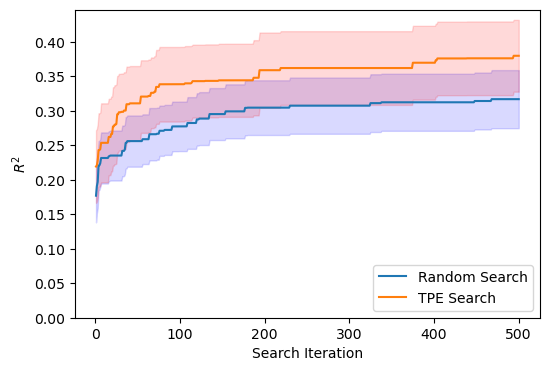

In [385]:
xs = list(range(1, rand_means.size(0) + 1))
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylabel('$R^2$')
ax.set_xlabel('Search Iteration')
ax.plot(xs, rand_means, label="Random Search")
ax.fill_between(xs, rand_lower, rand_upper, color='blue', alpha=.15)
ax.plot(xs, tpe_means, label="TPE Search")
ax.fill_between(xs, tpe_lower, tpe_upper, color='red', alpha=.15)
ax.set_ylim(ymin=0)
plt.legend(loc='lower right')
fig.savefig(config.FIGURES_DIR / 'ensemble_fitting.png')

## Explainability

## Zero-cost Proxies
### Correlations

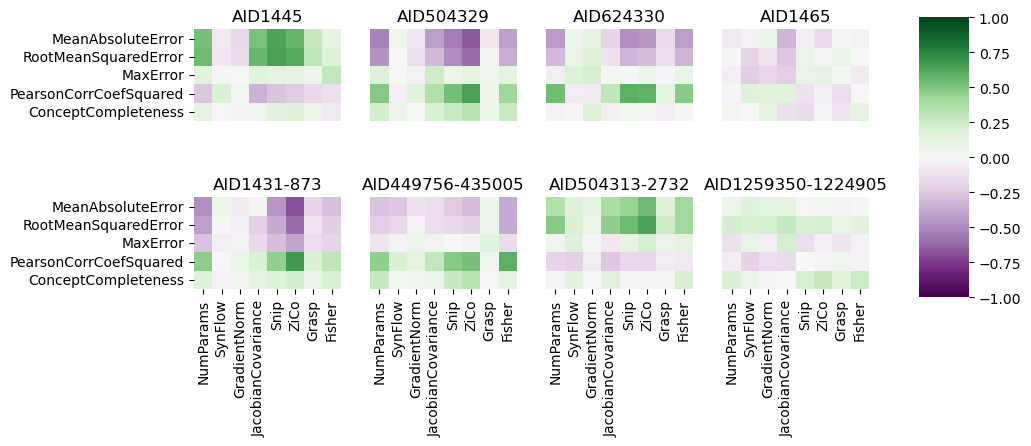

In [180]:
fig, axs = plt.subplots(2, 4, figsize=(10, 4))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
for i, (ax, dataset) in enumerate(zip(axs.flatten(), datasets)):
    ax.set_title(dataset)
    proxies, metrics = load_samples(dataset)
    proxies = {k: v.cpu().detach() for k, v in proxies.items()}
    metrics = {k: v.cpu().detach() for k, v in metrics.items()}
    experiment_df = pd.DataFrame(proxies | metrics)
    corrs = experiment_df.corr()
    sns.heatmap(
        corrs[proxy_names].loc[metric_names, :],
        xticklabels=i >= 4,
        yticklabels=i == 0 or i == 4,
        annot=False,
        square=True,
        ax=ax,
        cmap='PRGn',
        cbar_ax=cbar_ax,
        vmin=-1.0,
        vmax=1,
        center=0,
    )
fig.savefig(config.FIGURES_DIR / 'metric_proxy_correlations.png')

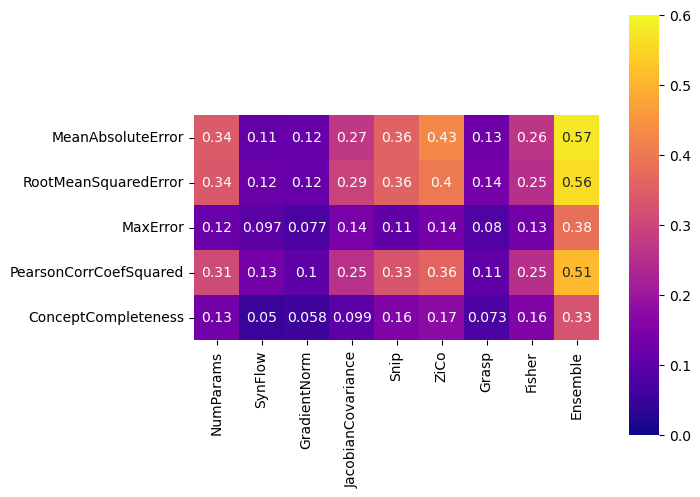

In [233]:
fig, ax = plt.subplots(figsize=(6, 6))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
dataset_corrs = []
for i, dataset in enumerate(datasets):
    proxies, metrics = load_samples(dataset)
    proxies = {k: v.cpu().detach() for k, v in proxies.items()}
    metrics = {k: v.cpu().detach() for k, v in metrics.items()}
    experiment_df = pd.DataFrame(proxies | metrics)
    corrs = experiment_df.corr().abs()
    corrs = corrs[proxy_names].loc[metric_names, :]
    
    # Calculate Ensemble values
    ensemble_corrs = {}
    for metric in metric_names:
        ensemble = Ensemble(DEFAULT_PROXIES)
        ensemble.fit(proxies, metrics[metric], not METRIC_HIGHER_IS_BETTER[metric])
        x = torch.stack([proxies[proxy] for proxy in ensemble.proxy_collection.proxies], dim=1)
        y = torch.tensor(ensemble.model.predict(x))
        ensemble_corrs[metric] = abs(pearsonr(y, metrics[metric]).statistic)
        
    corrs['Ensemble'] = pd.Series(ensemble_corrs)
    dataset_corrs.append(corrs)
        
avg_corrs = sum(dataset_corrs) / len(dataset_corrs)

sns.heatmap(
    avg_corrs,
    xticklabels=True,
    yticklabels=True,
    annot=True,
    square=True,
    ax=ax,
    cmap='plasma',
    cbar_ax=cbar_ax,
    vmin=0.0,
    vmax=0.6
)
fig.savefig(config.FIGURES_DIR / 'abs_metric_proxy_correlations.png')

### Proxy Fitting

In [118]:
min_samples = 2
max_samples = 50
dataset_losses = {}
for dataset in datasets:
    proxies, metrics = load_samples(dataset)
    train_proxies = {k: v[:max_samples] for k, v in proxies.items()}
    train_metrics = {k: v[:max_samples] for k, v in metrics.items()}
    train_labels = train_metrics['RootMeanSquaredError']
    test_proxies = {k: v[max_samples:] for k, v in proxies.items()}
    test_metrics = {k: v[max_samples:] for k, v in metrics.items()}
    test_labels = test_metrics['RootMeanSquaredError']
    average_losses = torch.zeros((1, max_samples-min_samples + 1))
    for _ in range(5):
        idxs = list(range(len(train_labels)))
        np.random.shuffle(idxs)
        losses = []
        for i in range(min_samples, max_samples+1):
            ensemble = Ensemble(DEFAULT_PROXIES)
            batch_idxs = idxs[:i]
            batch_proxies = {k:v[batch_idxs] for k,v in train_proxies.items()}
            batch_labels = train_labels[batch_idxs]
            proxy.fit(batch_proxies, batch_labels, True)
            x = torch.stack([test_proxies[proxy] for proxy in ensemble.proxy_collection.proxies], dim=1)
            y = torch.tensor(proxy.model.predict(x))
            losses.append(torch.mean((y.cpu() - test_labels.cpu()) ** 2).cpu().detach())
        average_losses += torch.tensor(losses)    
    dataset_losses[dataset] = average_losses / 5
    

In [119]:
losses = torch.cat([loss for loss in dataset_losses.values()], dim=0)
mins = losses.min(dim=1)[0].reshape(8, 1).expand(8, len(losses[0]))
maxs = losses.max(dim=1)[0].reshape(8, 1).expand(8, len(losses[0]))
losses = (losses - mins) / (maxs - mins)
means = torch.mean(losses, dim=0)
margin_of_error = 1.96 * torch.std(losses, dim=0) / len(datasets)
lower_bound = torch.clamp(means - margin_of_error, min=0)
upper_bound = means + margin_of_error

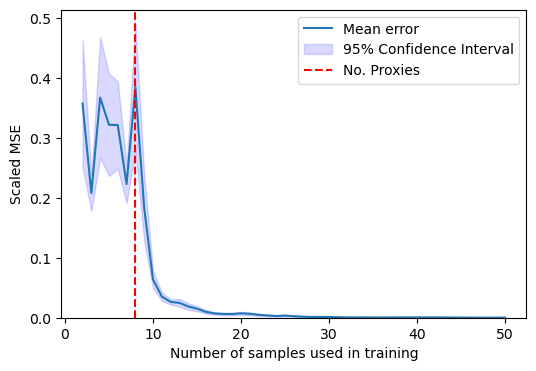

In [131]:
xs = list(range(min_samples, max_samples + 1))
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylabel("Scaled MSE")
ax.set_xlabel("Number of samples used in training")
ax.plot(xs, means, label="Mean error")
ax.fill_between(xs, lower_bound, upper_bound, color='b', alpha=.15, label="95% Confidence Interval")
ax.set_ylim(ymin=0)
ax.axvline(x=8, color='red', linestyle='--', label='No. Proxies')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper right')
fig.savefig(config.FIGURES_DIR / 'ensemble_fitting.png')